In [ ]:
# Libraries data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from keras.utils import plot_model

# Libraries for text preprocessing
!pip install nltk
import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

# Libraries for model development and training
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten, SimpleRNN
from keras.layers import Bidirectional, GlobalMaxPool1D, Convolution1D, MaxPooling1D, Conv1D
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# unziping the data zip file
import shutil
shutil.unpack_archive('/content/drive/MyDrive/Colab Notebooks/AmazonReviews.zip')

In [ ]:
# reading the csv file into pandas
data=pd.read_csv("AmazonReviews.csv")
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
# the label below 4 is set to 0 and the label above 3 is set to 1
labels = data['Score']
labels[labels<4] = 0
labels[labels>1] = 1
print(labels)

0         1
1         0
2         1
3         0
4         1
         ..
568449    1
568450    0
568451    1
568452    1
568453    1
Name: Score, Length: 568454, dtype: int64


<ipython-input-7-139f4eaff7b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[labels<4] = 0
<ipython-input-7-139f4eaff7b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels[labels>1] = 1


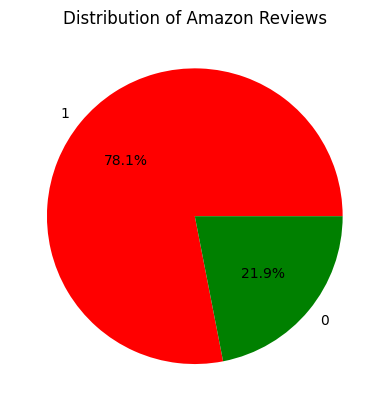

In [ ]:
label = labels.value_counts()

# Creating the pie chart
plt.pie(label, labels=label.index, autopct='%1.1f%%',  colors=['red', 'green'])
plt.title('Distribution of Amazon Reviews')
plt.show()

In [ ]:
# dropping duplicate texts and null values
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)
data.shape

(393565, 10)

In [ ]:
# map words to colloquial terms
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [ ]:
# custom stopwords
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
data['cleaned_text'] = data['Text'].apply(lambda x: preprocess_text(x))

<ipython-input-13-606cadd24beb>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags


In [ ]:
# cleaning the summary text of the data
data['cleaned_summary'] = data['Summary'].apply(lambda x: preprocess_text(x))

<ipython-input-13-606cadd24beb>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags


In [ ]:
data['cleaned_text'].head()

0    buy several vitality can dog food products fin...
1    product arrive label jumbo salt peanuts peanut...
2    confection around centuries light pillowy citr...
3    look secret ingredient robitussin believe find...
4    great taffy great price wide assortment yummy ...
Name: cleaned_text, dtype: object

In [ ]:
# print the first 5 samples in the data
for i in range(5):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'] [i])
    print("Score:",data['Score'][i])
    print("\n")

Review: buy several vitality can dog food products find good quality product look like stew process meat smell better labrador finicky appreciate product better 
Summary: good quality dog food
Score: 1


Review: product arrive label jumbo salt peanuts peanuts actually small size unsalted not sure error vendor intend represent product jumbo 
Summary: not advertise
Score: 0


Review: confection around centuries light pillowy citrus gelatin nut case filberts cut tiny square liberally coat powder sugar tiny mouthful heaven not chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduce edmund sell brother sisters witch 
Summary:  delight say
Score: 1


Review: look secret ingredient robitussin believe find get addition root beer extract order good make cherry soda flavor medicinal 
Summary: cough medicine
Score: 0


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal 
Summary: great taffy
Score: 1




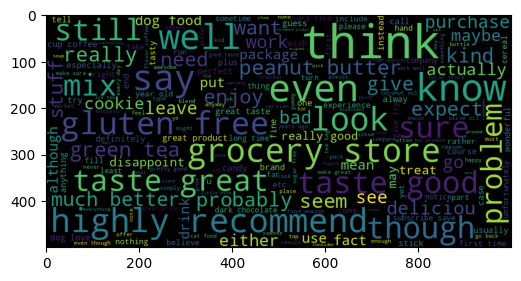

In [ ]:
# generate a word cloud to see more frequently used words
from wordcloud import WordCloud
allwords=''.join([i for i in data['cleaned_text']])
cloud=WordCloud(width=1000,height=500,random_state=42,max_font_size=100).generate(allwords)

plt.figure(figsize=(6, 4), dpi=100)
plt.imshow(cloud)
plt.show()

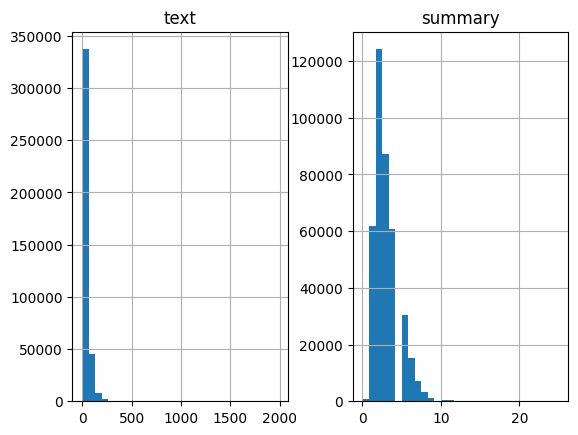

In [ ]:
# investigate the distribution of the length of
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()

In [ ]:
# split the data into train and test sets
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'] ,data['Score'],test_size=0.1,random_state=0,shuffle=True)

In [ ]:
# using the tokenizer object to tokenize 6000 most frequent words in the data
top_words = 6000

x_tokenizer = Tokenizer(num_words=top_words,lower=True, split=' ')
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr)
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=80, padding='post')
x_val   =   pad_sequences(x_val, maxlen=80, padding='post')

In [ ]:
# deep neural network using LSTM
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=80))
model.add(LSTM(100))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            192032    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 271345 (1.04 MB)
Trainable params: 271345 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


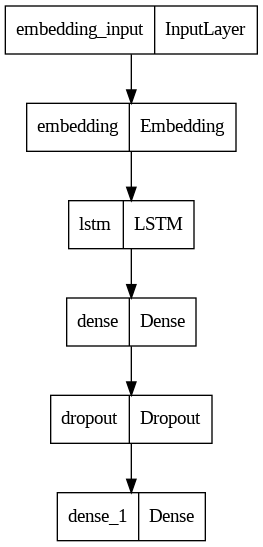

In [ ]:
# diagram of the model
plot_model(model, to_file='model.png')

In [ ]:
history =model.fit(x_tr,y_tr, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2
2768/2768 [==============================] - 61s 21ms/step - loss: 0.3157 - accuracy: 0.8691 - val_loss: 0.2867 - val_accuracy: 0.8883
Epoch 2/2
2768/2768 [==============================] - 28s 10ms/step - loss: 0.2474 - accuracy: 0.8997 - val_loss: 0.2447 - val_accuracy: 0.9004


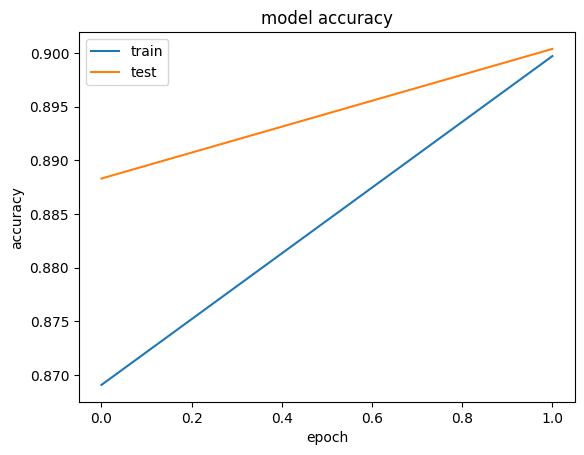

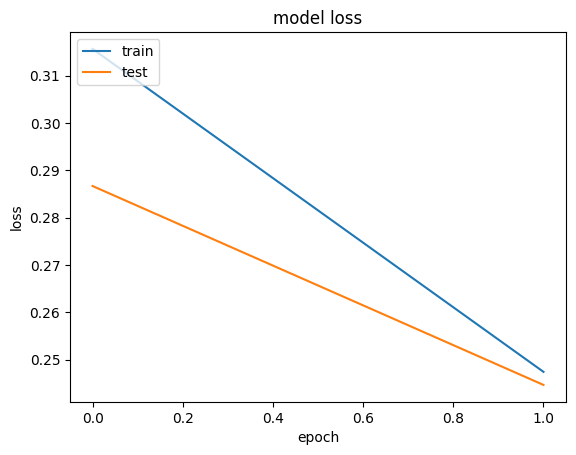

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# set random seedr
tf.keras.utils.set_random_seed(100)

In [ ]:
# deep neural network using LSTM with regularizers
embedding_vecor_length = 32
model5 = Sequential()
model5.add(Embedding(top_words+1, embedding_vecor_length, input_length=80))
model5.add(LSTM(100))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(1, kernel_regularizer=regularizers.l1(0.1), activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            192032    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 271345 (1.04 MB)
Trainable params: 271345 (1.04 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history5 = model5.fit(x_tr,y_tr, validation_data=(x_val, y_val), epochs=5, batch_size=128)

Epoch 1/5
2768/2768 [==============================] - 62s 21ms/step - loss: 0.5833 - accuracy: 0.7790 - val_loss: 0.5373 - val_accuracy: 0.7820
Epoch 2/5
2768/2768 [==============================] - 28s 10ms/step - loss: 0.5275 - accuracy: 0.7791 - val_loss: 0.5050 - val_accuracy: 0.7820
Epoch 3/5
2768/2768 [==============================] - 25s 9ms/step - loss: 0.5253 - accuracy: 0.7791 - val_loss: 0.5245 - val_accuracy: 0.7820
Epoch 4/5
2768/2768 [==============================] - 26s 9ms/step - loss: 0.4794 - accuracy: 0.7972 - val_loss: 0.3319 - val_accuracy: 0.8712
Epoch 5/5
2768/2768 [==============================] - 25s 9ms/step - loss: 0.3109 - accuracy: 0.8834 - val_loss: 0.2981 - val_accuracy: 0.8881


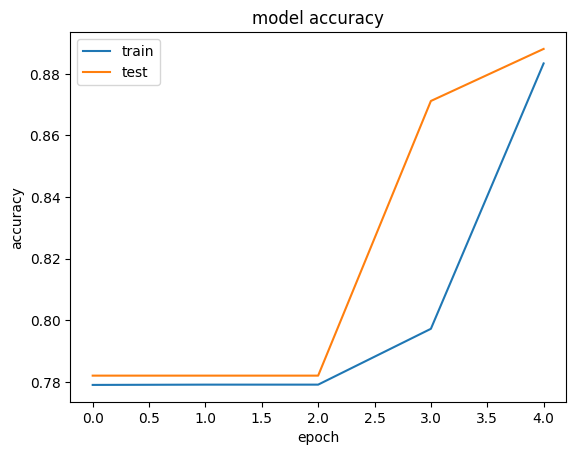

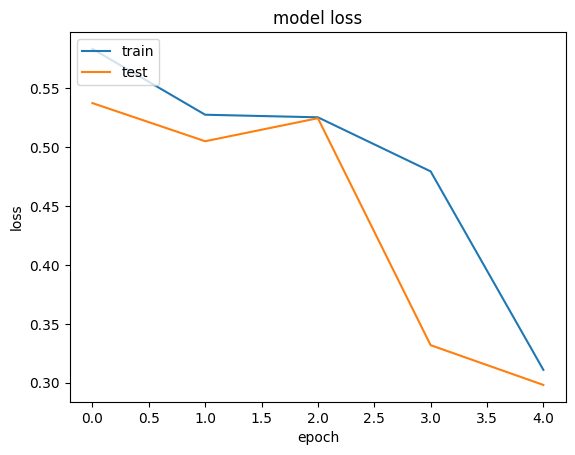

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# deep neural network using Feed Forward neural network
model1 = Sequential()
model1.add(Embedding(top_words, embedding_vecor_length, input_length=80))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
opt = tf.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            192000    
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense (Dense)               (None, 256)               655616    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 847873 (3.23 MB)
Trainable params: 847873 (3.23 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history1 = model1.fit(x_tr,y_tr, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2
2768/2768 [==============================] - 68s 24ms/step - loss: 0.2882 - accuracy: 0.8780 - val_loss: 0.2772 - val_accuracy: 0.8824
Epoch 2/2
2768/2768 [==============================] - 18s 6ms/step - loss: 0.2395 - accuracy: 0.9003 - val_loss: 0.2773 - val_accuracy: 0.8848


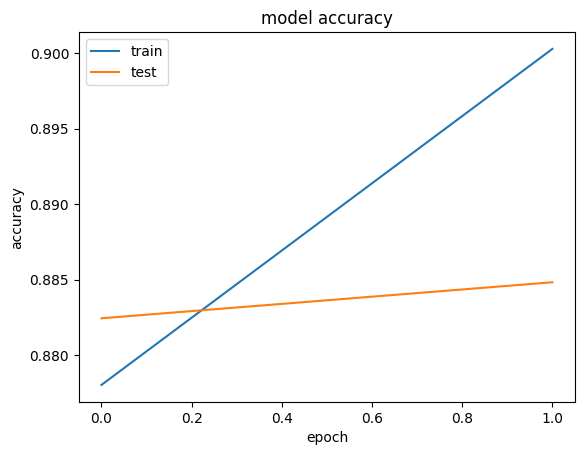

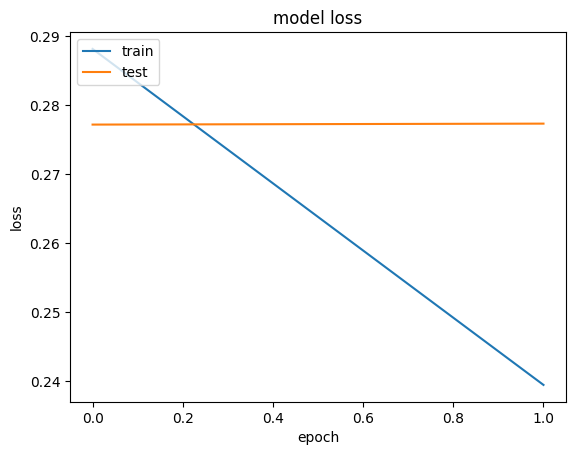

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# set random seed
tf.keras.utils.set_random_seed(100)

In [ ]:
# deep neural network using One Dimensional Convolutional Neural Network
model2 = Sequential()
model2.add(Embedding(top_words, 32, input_length=80))
model2.add(Conv1D(300, 3, padding='same', activation='relu'))
model2.add(MaxPooling1D())
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            192000    
                                                                 
 conv1d (Conv1D)             (None, 80, 300)           29100     
                                                                 
 max_pooling1d (MaxPooling1  (None, 40, 300)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12000)             0         
                                                                 
 dense (Dense)               (None, 256)               3072256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [ ]:
history2 = model2.fit(x_tr,y_tr, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2
2768/2768 [==============================] - 56s 19ms/step - loss: 0.2751 - accuracy: 0.8857 - val_loss: 0.2499 - val_accuracy: 0.8969
Epoch 2/2
2768/2768 [==============================] - 23s 8ms/step - loss: 0.2230 - accuracy: 0.9095 - val_loss: 0.2340 - val_accuracy: 0.9042


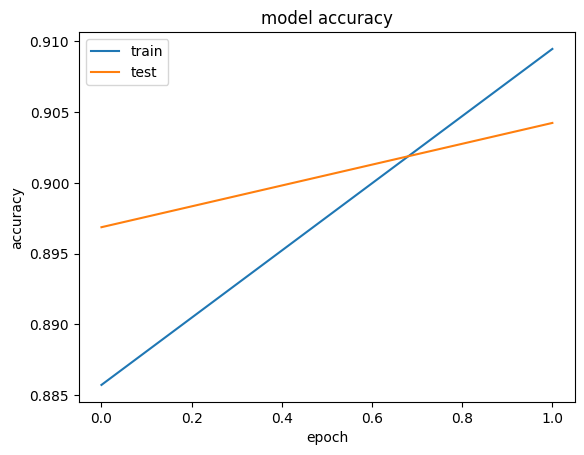

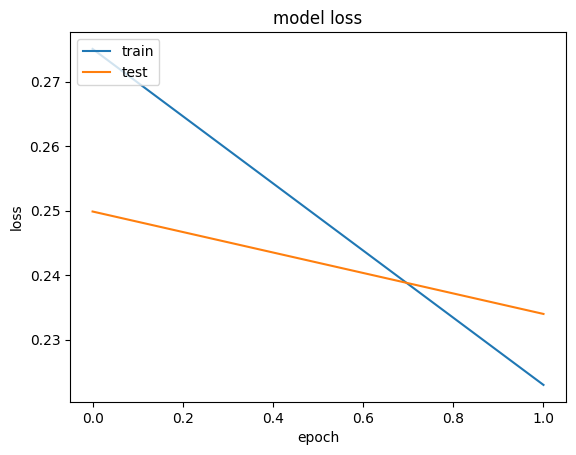

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# set random seed
tf.keras.utils.set_random_seed(100)

In [ ]:
# deep neural network using SimpleRNN
model3 = Sequential()
model3.add(Embedding(top_words, 32, input_length=80))
model3.add(SimpleRNN(256))
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            192000    
                                                                 
 conv1d (Conv1D)             (None, 80, 300)           29100     
                                                                 
 max_pooling1d (MaxPooling1  (None, 40, 300)           0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 12000)             0         
                                                                 
 dense (Dense)               (None, 256)               3072256   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                        

In [ ]:
history3 = model3.fit(x_tr,y_tr, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2
2768/2768 [==============================] - 271s 97ms/step - loss: 0.5148 - accuracy: 0.7757 - val_loss: 0.4819 - val_accuracy: 0.7820
Epoch 2/2
2768/2768 [==============================] - 230s 83ms/step - loss: 0.4882 - accuracy: 0.7787 - val_loss: 0.4862 - val_accuracy: 0.7820


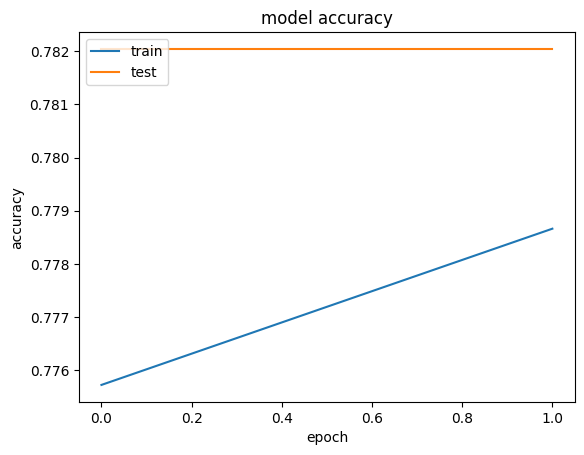

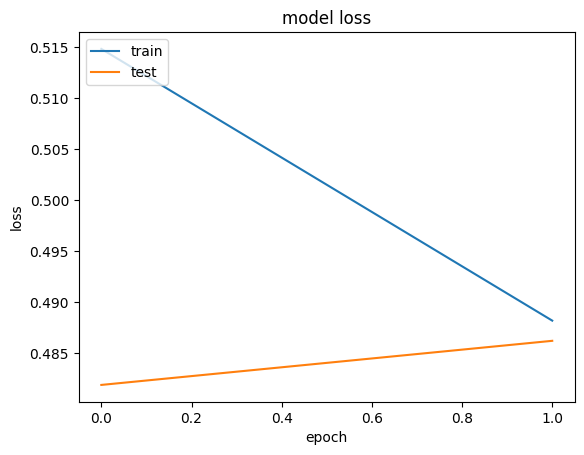

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# set random seed
tf.keras.utils.set_random_seed(100)

In [ ]:
# deep neural network using GRU
model4 = Sequential()
model4.add(Embedding(top_words, 32, input_length=80))
model4.add(GRU(256, return_sequences=True))
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 80, 32)            192000    
                                                                 
 gru (GRU)                   (None, 80, 256)           222720    
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 256)               5243136   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 5658113 (21.58 MB)
Trainable params: 56581

In [ ]:
history4 = model4.fit(x_tr,y_tr, validation_data=(x_val, y_val), epochs=2, batch_size=128)

Epoch 1/2
2768/2768 [==============================] - 75s 26ms/step - loss: 0.2839 - accuracy: 0.8813 - val_loss: 0.2699 - val_accuracy: 0.8854
Epoch 2/2
2768/2768 [==============================] - 43s 16ms/step - loss: 0.2297 - accuracy: 0.9063 - val_loss: 0.2343 - val_accuracy: 0.9023


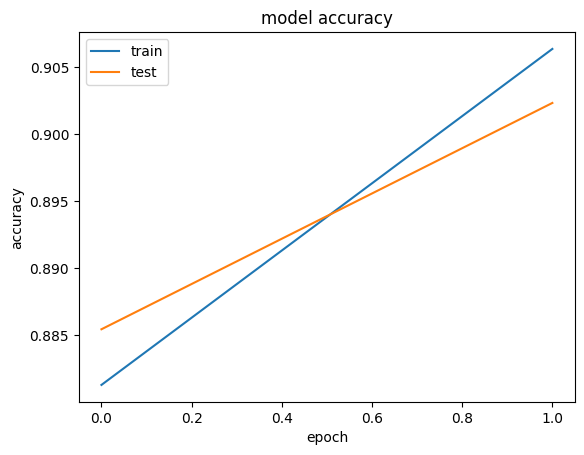

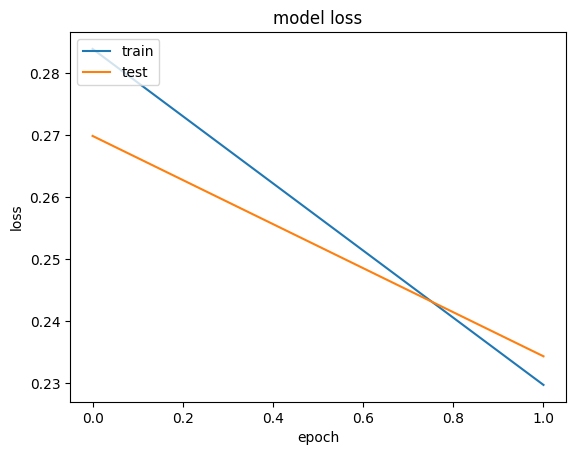

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()